In [1]:
#!conda info

In [2]:
import re
import numpy as np
import pandas as pd
#from nltk.tokenize import word_tokenize
#from nltk.stem import WordNetLemmatizer

from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from sqlalchemy import create_engine

In [5]:
msg_df = pd.read_csv('/data2/home/prasannaiyer/Projects/NLP_Project/Data/disaster_messages.csv')

In [6]:
category_df = pd.read_csv('/home/prasannaiyer/Projects/NLP_Project/Data/disaster_categories.csv')

In [7]:
consol_df = msg_df.merge(category_df, left_on = 'id', right_on = 'id')

### Question 1: What is the count of messages by genre?

In [8]:
msg_genre = pd.Series(data = msg_df['genre'].value_counts().values/msg_df['genre'].value_counts().sum(), \
    index = msg_df['genre'].value_counts().index)
msg_genre = (msg_genre*100).round(0).astype(int)

[Text(0, 0, '13068'), Text(0, 0, '10782'), Text(0, 0, '2398')]

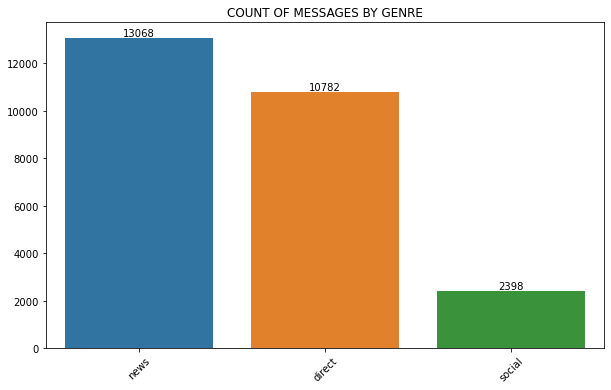

In [9]:
plt.figure(figsize = (10, 6))
ax = sns.barplot(x = msg_df['genre'].value_counts().index, y = msg_df['genre'].value_counts().values)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)
ax.set_title('COUNT OF MESSAGES BY GENRE')
ax.bar_label(ax.containers[0])



### Question 2: Are there any null values in the message dataset?

In [10]:
##WIP
consol_df.head()

,id,message,original,genre,categories
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,related-1;request-0;offer-0;aid_related-0;medi...
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,related-1;request-0;offer-0;aid_related-1;medi...
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,related-1;request-0;offer-0;aid_related-0;medi...
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,related-1;request-1;offer-0;aid_related-1;medi...
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,related-1;request-0;offer-0;aid_related-0;medi...


In [11]:
categories = consol_df['categories'].str.split(pat = ';', expand = True)

In [12]:
##WIP
categories.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
1,related-1,request-0,offer-0,aid_related-1,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-1,floods-0,storm-1,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
2,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
3,related-1,request-1,offer-0,aid_related-1,medical_help-0,medical_products-1,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
4,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0


In [13]:
cat_names = categories[0:1].apply(lambda x: x.str[:-2]).astype(str)

In [14]:
##WIP
cat_names

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report


In [15]:
categories.columns = cat_names.values.flatten().tolist()

In [16]:
##WIP
categories['related'].value_counts()

related-1    20042
related-0     6140
related-2      204
Name: related, dtype: int64

In [17]:
##WIP
for column in categories.columns:
    #if categories[column].str[-1] not in ['0','1']:
    print('column name --', column, 'last char -- ',categories[column].str[-1].unique().size )
    

        


column name -- related last char --  3
column name -- request last char --  2
column name -- offer last char --  2
column name -- aid_related last char --  2
column name -- medical_help last char --  2
column name -- medical_products last char --  2
column name -- search_and_rescue last char --  2
column name -- security last char --  2
column name -- military last char --  2
column name -- child_alone last char --  1
column name -- water last char --  2
column name -- food last char --  2
column name -- shelter last char --  2
column name -- clothing last char --  2
column name -- money last char --  2
column name -- missing_people last char --  2
column name -- refugees last char --  2
column name -- death last char --  2
column name -- other_aid last char --  2
column name -- infrastructure_related last char --  2
column name -- transport last char --  2
column name -- buildings last char --  2
column name -- electricity last char --  2
column name -- tools last char --  2
column na

In [18]:
for column in categories.columns:
    categories[column] = categories[column].str[-1].astype(int)
    categories[column] = categories[column].apply(lambda x: 1 if x > 1 else x)

In [19]:
##WIP
categories.head()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
msg_cat_df = pd.concat([consol_df, categories], axis = 1)

In [21]:
msg_cat_df.drop(columns = ['categories'], axis = 1, inplace = True)

In [22]:
msg_cat_clean_df = msg_cat_df.drop_duplicates()

In [23]:
msg_cat_df[msg_cat_df.duplicated()].shape

(171, 40)

In [24]:
msg_cat_clean_df[msg_cat_clean_df.duplicated()].shape

(0, 40)

In [25]:
msg_cat_clean_df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
engine = create_engine('sqlite:////home/prasannaiyer/Projects/NLP_Project/Data/DisasterResponse.db')

In [29]:
msg_cat_clean_df.to_sql('Message_Category', engine, index=False, if_exists = 'replace')